<a href="https://colab.research.google.com/github/HwangHanJae/ml-definitive-guide-pratice/blob/main/sklearn_titanic_survived_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

타이타닉 탑승자 데이터
- Passengerid : 탑승자 데이터 일련번호
- Survived : 생존여부, 0=사망, 1=생존
- Pclass : 티켓의 선실 등급, 1=일등석, 2=이등석, 3=삼등석
- Name : 탑승자 이름
- Sex : 탑승자 성별
- Age : 탑승자 나이
- SibSp : 같이 탑승한 형제자매 또는 배우자 인원수
- Parch : 같이 탑승한 부모님 또는 어린이 인원수
- Ticket : 티켓 번호
- Fare : 요금
- Cabin : 선실번호
- Embarked : 중간정착항구 C=Cherbourg, Q=Queenstown, S=Southampton

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

train_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/test.csv"
submission_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/gender_submission.csv"
titanic_df = pd.read_csv(train_path)

titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
#로딩된 데이터 칼럼 타입 확인
print("\n ### 학습 데이터 정보 ###")
print(titanic_df.info())


 ### 학습 데이터 정보 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


891개의 로우와 12개의 칼럼으로 구성

2개의 칼럼은 float64, 5개의 칼럼은 int64, 5개의 칼럼은 object로 구성

Age, Cabin, Embarked 컬럼은 Null값을 가지고 있음
  - 각각 177개, 608개, 2개
  

In [7]:
#Null값 처리
#Age는 평균, 나머지컬럼은 N으로 처리

titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())
titanic_df['Cabin'] = titanic_df['Cabin'].fillna("N")
titanic_df['Embarked'] = titanic_df['Embarked'].fillna("N")

#다시 Null값 확인
print("데이터 세트 Null 값 개수 : ", (titanic_df.isnull().sum()).sum())

데이터 세트 Null 값 개수 :  0


In [13]:
#object타입의 컬럼 5개이지만 그중 Name, Ticket은 이름과 티켓은 id처럼 분포를 알기 힘들기에
#Sex, Cabin, Embarked 항목만 분포를 확인

print("Sex 값 분포 : \n", titanic_df['Sex'].value_counts())
print("\nCabin 값 분포 : \n", titanic_df['Cabin'].value_counts())
print("\nEmbarked 값 분포 : \n", titanic_df['Embarked'].value_counts())

Sex 값 분포 : 
 male      577
female    314
Name: Sex, dtype: int64

Cabin 값 분포 : 
 N              687
B96 B98          4
G6               4
C23 C25 C27      4
D                3
              ... 
B50              1
C128             1
C50              1
E46              1
A34              1
Name: Cabin, Length: 148, dtype: int64

Embarked 값 분포 : 
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


Sex, Embarked 컬럼은 별 문제가 없어보임 

하지만 Cabin 컬럼은 N이 687건으로 가장 많은 것으로 특이하며
B96 B98, C23 C25 C27 처럼 속성값이 제대로 정리 되지 않음

Cabin 컬럼에서 중요한것은 첫번째 단어 B, C, D로 보임

이것은 선실의 등급을 나타내는 것으로 지금보다 예전이 더 돈이 많은 사람과 적은 사람의 차별이 더 있을것으로 보임, 생존 확률에도 영향을 줄것으로 예상함


In [17]:
#Cabin의 앞글자만 추출
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
titanic_df['Cabin'].head(3)

0    N
1    C
2    N
Name: Cabin, dtype: object

In [18]:
#성별에 따른 생존자 수를 확인
titanic_df.groupby(["Sex", "Survived"])["Sex"].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Sex, dtype: int64

남성에 비하여 여성이 더 생존자수가 많아보임

이 당시에는 여성과 아이들, 노약자가 구조대상의 높은 우선순위를 가졌을 것이며 다음은 부자와 유명인일 것으로 추측함


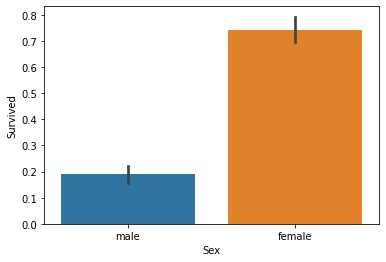

In [20]:
#성별에 따른 생존자 수를 보기 쉽게 그래프로 확인
sns.barplot(data=titanic_df,x="Sex", y="Survived")

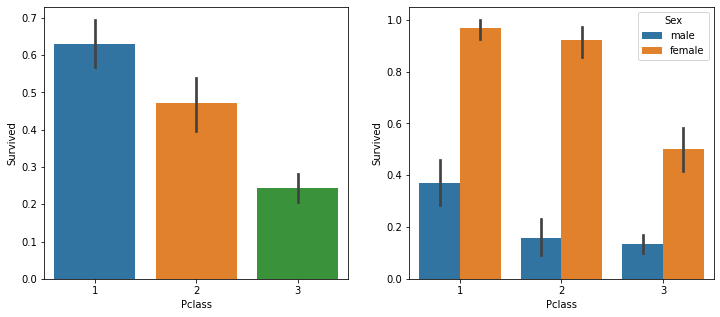

In [32]:
#부자와 가난한사람의 생존사를 비교함
#Pclass를 이용하여 부자와 가난한사람을 구분할 수 있음
f, ax = plt.subplots(1,2, figsize=(12, 5))

sns.barplot(data=titanic_df, x='Pclass', y='Survived', ax=ax[0])
sns.barplot(data=titanic_df, x='Pclass', y='Survived', hue='Sex', ax=ax[1])

왼쪽의 그래프는 Pclass에 따른 생존자이다.
- 객실등급순으로 생존확률이 높음
  - 1 > 2 > 3

오른쪽의 그래프는 Pclass별 성별에 따른 생존자이다.
  - 1,2 등급의 객실의 여성이 생존확률이 높으며 3등급의 객실의 여성의 생존확률이 많이 낮은 것을 볼 수 있다.

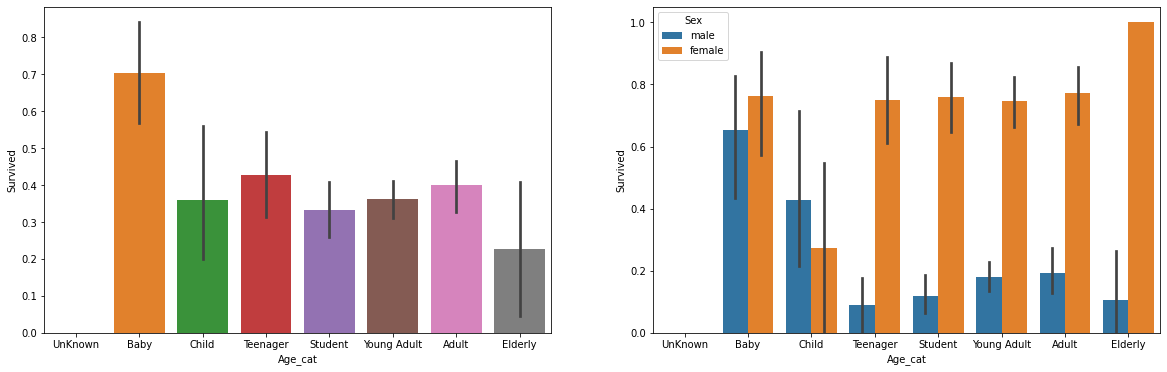

In [37]:
#Age에 따른 생존확률을 알아보기

#Age 컬럼은 연속형 변수이기 때문에 범주화를 한 후에 그래프로 확인하겠음

def get_category(age):
  cat = ''
  if age <= -1 : cat = "UnKnown"
  elif age <= 5 : cat = "Baby"
  elif age <= 12 : cat ="Child"
  elif age <= 18 : cat = "Teenager"
  elif age <= 25 : cat = "Student"
  elif age <= 35 : cat = "Young Adult"
  elif age <= 60 : cat = "Adult"
  else : cat = "Elderly"

  return cat

#위에서 만든 함수를 apply함수로 적용해 'Age_cat' 컬럼을 생성
titanic_df['Age_cat'] = titanic_df["Age"].apply(lambda x : get_category(x))

group_names = ["UnKnown","Baby","Child","Teenager","Student","Young Adult", "Adult","Elderly"]

#그래프로 확인
f, ax = plt.subplots(1,2,figsize=(20,6))
sns.barplot(data=titanic_df, x='Age_cat', y="Survived",order =group_names, ax=ax[0])
sns.barplot(data=titanic_df, x='Age_cat', y="Survived",order =group_names, hue="Sex", ax=ax[1])

왼쪽의 그래프는 Age_cat별 생존확률이다.
  - Baby의 생존확률이 가장 높은 것을 볼 수 있음
  
오른쪽의 그래프는 Age_cat별 성별에 따른 생존확률이다.
  - 여성 Baby의 경우 생존 확률이 가장 높지만 Child의 경우는 그렇지 않음
  - 여성 Elderly의 경우도 역시 생존확률이 높음

In [41]:
#LabelEncoder 클래스를 이용하여 인코딩을 적용
from sklearn.preprocessing import LabelEncoder
def encode_features(df):
  features = ["Cabin","Sex","Embarked"]
  for feature in features:
    encoder = LabelEncoder()
    encoder.fit(df[feature])
    df[feature] = encoder.transform(df[feature])

  return df

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3,6
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3,6
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3,6


In [85]:
#위에서 했던 작업들을 수행하기 편하게 함수로 정리

#Null(결측값)처리
def fillna(df):
  df["Age"] = df["Age"].fillna(df["Age"].mean())
  df["Cabin"] = df['Cabin'].fillna("N")
  df["Embarked"] = df["Embarked"].fillna("N")
  df["Fare"] = df["Fare"].fillna(0)

  return df

#불필요한 속성 제거
def drop_features(df):
  drop_col = ["PassengerId", "Name", "Ticket"]
  df.drop(drop_col, axis=1, inplace = True)
  return df

#LabelEncoding 수행

def format_features(df):
  from sklearn.preprocessing import LabelEncoder
  df["Cabin"] = df["Cabin"].str[:1]
  features = ["Cabin", "Sex","Embarked"]
  for feature in features:
    encoder = LabelEncoder()
    encoder.fit(df[feature])
    df[feature] = encoder.transform(df[feature])
  return df

#위에서 작성한 함수를 실행하는 함수
def transform_features(df):
  fillna(df)
  drop_features(df)
  format_features(df)
  return df

In [86]:
#원본 데이터를 다시 추출
df = pd.read_csv(train_path)

#타겟데이터 분리
X = df.drop("Survived", axis=1)
y = df["Survived"].copy()

#위에서 정리한 데이터 전처리 실행

X = transform_features(X)

X.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,7,3
1,1,0,38.0,1,0,71.2833,2,0
2,3,0,26.0,0,0,7.9250,7,3
3,1,0,35.0,1,0,53.1000,2,3
4,3,1,35.0,0,0,8.0500,7,3


In [87]:
#학습데이터(80%) / 테스트데이터(20%) 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=11)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 8) (712,)
(179, 8) (179,)


In [88]:
#여러 ML 알고리즘을 사용하여 분류
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#여러 모델 객체생성
seed = 11
tree = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
lr = LogisticRegression()

#모델을 학습/예측/평가
models = [tree, rf, lr]
for model in models:
  model.fit(X_train, y_train)
  predict = model.predict(X_test)
  score = accuracy_score(y_test, predict)
  print("{}의 정확도는 {}".format(model.__class__.__name__, round(score, 4)))
  

DecisionTreeClassifier의 정확도는 0.7877
RandomForestClassifier의 정확도는 0.8547
LogisticRegression의 정확도는 0.8492


최적화 작업을 진행하지 않고, 데이터 양도 충분하지 않아서 어떤 알고리즘이 가장 성능이 좋다고는 못함


In [89]:
#교차검증을 진행(KFold, cross_val_score(), GridSearchCV 모두 진행)
#KFold 교차검증을 함수로 만들어 진행
def exec_kfold(clf, folds=5):
  from sklearn.model_selection import KFold
  #폴드 세트를 5개인 KFold 객체를 생성, 폴드 수만큼 예측 결과 저장을 위한 리스트 객체 생성.
  kfold = KFold(n_splits=folds)
  scores = []
  #KFold 교차검증 수행
  print("{} : ".format(clf.__class__.__name__))
  for i,(train_index, val_index) in enumerate(kfold.split(X),1):
    #X 데이터에서 교차 검증별로 학습과 검증데이터를 가리키는 index 생성
    X_train, X_test = X.values[train_index], X.values[val_index]
    y_train, y_test = y.values[train_index], y.values[val_index]

    #모델 학습/예측/정확도
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predict)
    scores.append(accuracy)
    print("교차 검증{} 정확도 : {}".format(i, round(accuracy,4)))

  print("평균 정확도 : ", round(np.mean(scores), 4))

In [90]:
from sklearn.tree import DecisionTreeClassifier
seed = 11
tree = DecisionTreeClassifier(random_state=seed)
exec_kfold(tree)

DecisionTreeClassifier : 
교차 검증1 정확도 : 0.7542
교차 검증2 정확도 : 0.7809
교차 검증3 정확도 : 0.7865
교차 검증4 정확도 : 0.7697
교차 검증5 정확도 : 0.8202
평균 정확도 :  0.7823


In [91]:
from sklearn.ensemble import RandomForestClassifier
seed = 11
rf = RandomForestClassifier(random_state=seed)
exec_kfold(rf)

RandomForestClassifier : 
교차 검증1 정확도 : 0.7933
교차 검증2 정확도 : 0.809
교차 검증3 정확도 : 0.8371
교차 검증4 정확도 : 0.7753
교차 검증5 정확도 : 0.8596
평균 정확도 :  0.8148


In [92]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
exec_kfold(lr)

LogisticRegression : 
교차 검증1 정확도 : 0.8045
교차 검증2 정확도 : 0.7809
교차 검증3 정확도 : 0.7753
교차 검증4 정확도 : 0.7472
교차 검증5 정확도 : 0.809
평균 정확도 :  0.7834


In [103]:
#cross_val_score() 진행
def fun_cross_val_score(clf, X, y, cv=5):
  from sklearn.model_selection import cross_val_score
  scores = cross_val_score(estimator=clf, X=X, y=y,cv=cv, n_jobs=-1, scoring='accuracy')
  print("{} : ".format(clf.__class__.__name__))
  for i, accuracy in enumerate(scores, 1):
    print("교차 검증 {} 정확도 : ".format(i, round(accuracy, 4)))

  print("평균 정확도 : ", round(np.mean(scores),4))

In [104]:
tree = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
lr = LogisticRegression()

models = [tree, rf, lr]
for model in models:
  fun_cross_val_score(model, X, y)

DecisionTreeClassifier : 
교차 검증 1 정확도 : 
교차 검증 2 정확도 : 
교차 검증 3 정확도 : 
교차 검증 4 정확도 : 
교차 검증 5 정확도 : 
평균 정확도 :  0.7879
RandomForestClassifier : 
교차 검증 1 정확도 : 
교차 검증 2 정확도 : 
교차 검증 3 정확도 : 
교차 검증 4 정확도 : 
교차 검증 5 정확도 : 
평균 정확도 :  0.8137
LogisticRegression : 
교차 검증 1 정확도 : 
교차 검증 2 정확도 : 
교차 검증 3 정확도 : 
교차 검증 4 정확도 : 
교차 검증 5 정확도 : 
평균 정확도 :  0.7845


In [105]:
#학습데이터(80%) / 테스트데이터(20%) 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=11)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 8) (712,)
(179, 8) (179,)


In [112]:
#GridSearchCV를 사용
def grid_search(clf, parameters,cv=5):
  from sklearn.model_selection import GridSearchCV
  from sklearn.metrics import accuracy_score
  grid = GridSearchCV(clf, param_grid = parameters, scoring='accuracy',cv=cv)
  grid.fit(X_train, y_train)
  print("{} : ".format(clf.__class__.__name__))
  print("GridSearchCV 최적 하이퍼 파라미터 : ", grid.best_params_)
  print("GridSearchCV 최고 정확도 : {}".format(round(grid.best_score_,4)))

  best_clf = grid.best_estimator_

  pred = best_clf.predict(X_test)
  accuracy = accuracy_score(y_test, pred)
  print("테스트 세트에서의 {} 정확도 : {}".format(clf.__class__.__name__,round(accuracy, 4)))

In [113]:
#tree GridSearchCV 적용
tree = DecisionTreeClassifier(random_state=seed)
parameters = {"max_depth" : [2,3,5,10],
              "min_samples_split" : [2,3,5],
              "min_samples_leaf" : [1,5,8]}

grid_search(tree, parameters)

DecisionTreeClassifier : 
GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도 : 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


In [117]:
rf = RandomForestClassifier(random_state=seed)
parameters = {"max_depth" : [2,3,5,10],
              "min_samples_split" : [2,3,5],
              "min_samples_leaf" : [1,5,8],
              "n_estimators": [100,500,1000]}

grid_search(rf, parameters)

RandomForestClassifier : 
GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
GridSearchCV 최고 정확도 : 0.816
테스트 세트에서의 RandomForestClassifier 정확도 : 0.8715


In [118]:
lr = LogisticRegression(n_jobs=-1)
parameters = {"max_iter" : [100,300,500,1000],
              }

grid_search(lr, parameters)

LogisticRegression : 
GridSearchCV 최적 하이퍼 파라미터 :  {'max_iter': 100}
GridSearchCV 최고 정확도 : 0.7795
테스트 세트에서의 LogisticRegression 정확도 : 0.8492
